# Chebyshev FFT

In [1]:
include("smij-functions.jl");

## p18: Chebyshev differentiation via FFT (compare p11)

In [2]:
u = x -> exp(x) * sin(5x) 
uʹ = x -> exp(x) * (sin(5x) + 5 * cos(5x))
xx = (-200:200) / 200
vv = @. u.(xx)
results = []
for (i,N) in enumerate([10, 20])
    _, x = cheb(N)
    v = u.(x)
    error = chebfft(v) - uʹ.(x)
    ee = polyinterp(x, error).(xx)
    push!(results, (;x,v,error,ee))
end

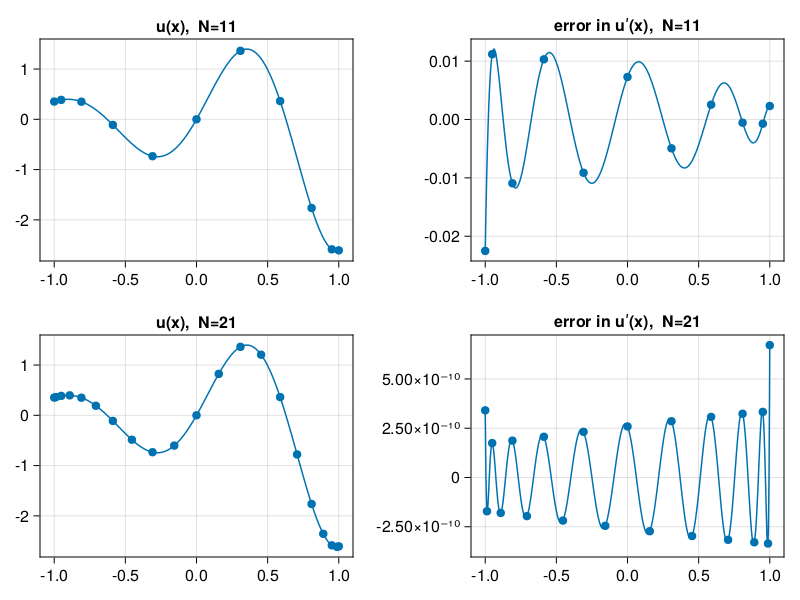

In [3]:
using CairoMakie
fig = Figure()
for (i,r) in enumerate(results)
    N = length(r.x)
    Axis(fig[i, 1], title="u(x),  N=$N")
    scatter!(r.x, r.v)
    lines!(xx, vv)
    Axis(fig[i, 2], title="error in uʹ(x),  N=$N")
    scatter!(r.x, r.error)
    lines!(xx, r.ee)
end
fig

## p19: 2nd-order wave eq. on Chebyshev grid (compare p6)

In [4]:
# Time-stepping by leap frog formula:
N = 80
_, x = cheb(N)
Δt = 8 / N^2
v = @. exp(-200 * x^2)
vold = @. exp(-200 * (x - Δt)^2)

tmax = 4
nsteps = ceil(Int, tmax / Δt)
Δt = tmax / nsteps
V = [v fill(NaN, N+1, nsteps)]
t = Δt*(0:nsteps)
for i in 1:nsteps
    w = chebfft(chebfft(V[:,i]))
    w[1] = w[N+1] = 0
    V[:,i+1] = 2V[:,i] - vold + Δt^2 * w
    vold = V[:,i]
    if norm(V[:,i+1], Inf) > 2.5
        nsteps = i
        break 
    end
end

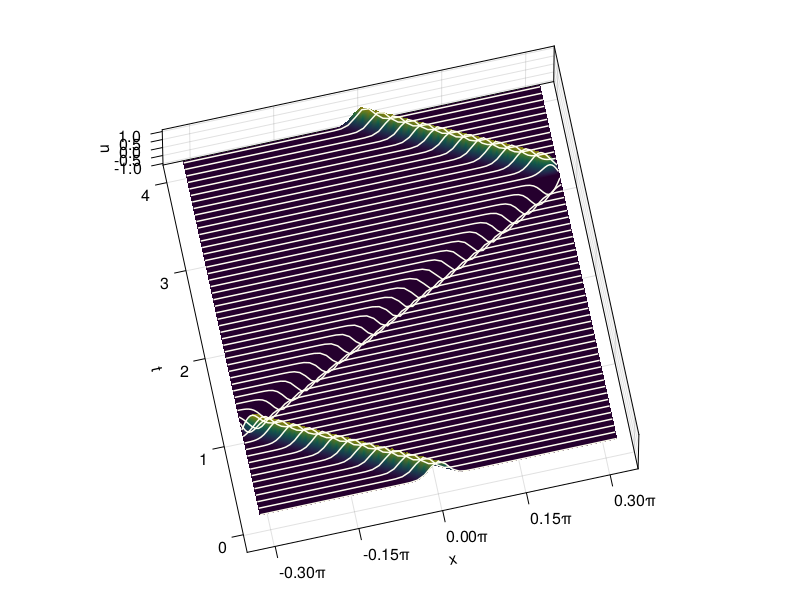

In [5]:
using PyFormattedStrings
# Plot results:
fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.44,
)
gap = max(1,round(Int, 0.075/(t[2]-t[1])) - 1)
surface!(x, t, V, colorrange=(0,1))
[ lines!(x, fill(t[j], length(x)), V[:, j].+.01, color=:ivory) for j in 1:gap:size(V,2) ]
fig

In [6]:
fig = Figure(size=(480,360))
index = Observable(1)
ax = Axis(fig[1, 1],xlabel="x", ylabel="u" )
lines!(x, @lift(V[:,$index]))
record(fig, "_build/html/p19wave.mp4", 1:6:size(V,2)+1) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
    limits!(-1,1,-1,1)
end;

<video autoplay controls><source src="p19wave.mp4" type="video/mp4"></video>


## p20: 2nd-order wave eq. in 2D via FFT (compare p19)

In [7]:
# Grid and initial data:
N = 32
x = y = cheb(N)[2]
Δt = 6 / N^2
xx = yy = range(-1,1,81)
nsteps = ceil(Int, 1 / Δt)
Δt = 1 / nsteps

vv = [exp(-40 * ((x - 0.4)^2 + y^2)) for x in x, y in y]
vvold = vv

t = Δt*(0:nsteps)
V = zeros(length(xx),length(yy),nsteps+1)
V[:,:,1] = gridinterp(vv,xx,yy)

# Time-stepping by leap frog formula:
uxx = zeros(N+1, N+1)
uyy = zeros(N+1, N+1)
for n in 1:nsteps
    ii = 2:N
    for i in 2:N
        uxx[i,:] .= chebfft(chebfft(vv[i,:]))
        uyy[:,i] .= chebfft(chebfft(vv[:,i]))
    end
    uxx[[1,N+1],:] .= uyy[[1,N+1],:] .= 0
    uxx[:,[1,N+1]] .= uyy[:,[1,N+1]] .= 0
    vvnew = 2vv - vvold + Δt^2 * (uxx + uyy)
    vvold,vv = vv,vvnew
    V[:,:,n+1] = gridinterp(vv,xx,yy)
end

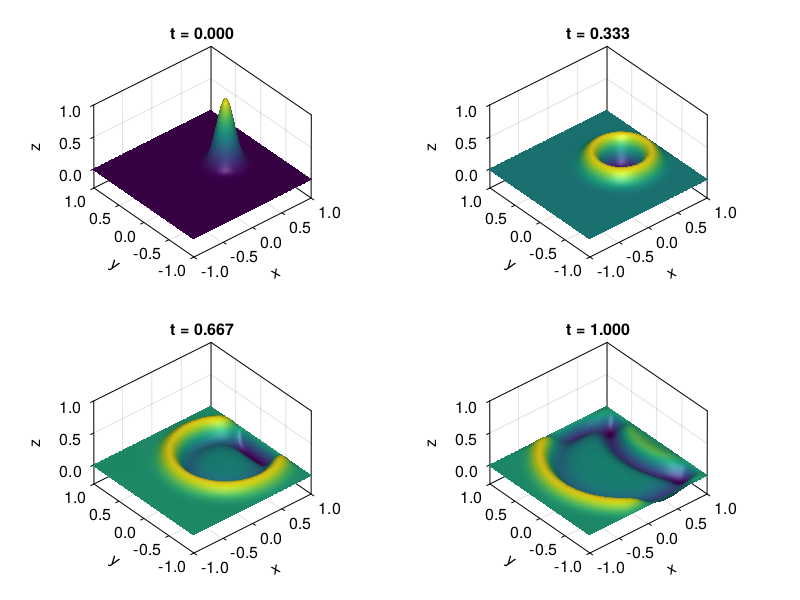

In [8]:
inc = div(nsteps,3)
fig = Figure()
ax = [ Axis3(fig[j,i], zticks=[0,0.5,1]) for i in 1:2, j in 1:2 ]
for (i,n) in enumerate(1:inc:nsteps+1) 
    surface!(ax[i],xx,yy,V[:,:,n])
    ax[i].title = f"t = {t[n]:.3f}"
    limits!(ax[i],-1,1,-1,1,-0.3,1)
    ax[i].elevation = π/5
end
fig

In [9]:
fig = Figure(size=(480,320))
index = Observable(1)
# ax = Axis(fig[1, 1], xlabel="x", ylabel="y", aspect=DataAspect())
ax = Axis3(fig[1, 1], xlabel="x", ylabel="y", azimuth=-π/2, elevation=π/2)
# co = contourf!(ax,xx, yy, @lift(V[:,:,$index]), 
#     levels=range(-0.3,1,24),
#     colormap=:bluesreds )
co = surface!(xx, yy, @lift(V[:,:,$index]), 
        colormap=:bluesreds, colorrange=[-0.8,0.8] )
record(fig, "_build/html/p20wave.mp4", 1:size(V,3)) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
end;

<video autoplay controls><source src="p20wave.mp4" type="video/mp4"></video>